In [136]:
import numpy as np
import casadi.casadi as cs
import scipy.optimize as sopt
import matplotlib.pyplot as plt

## 1. Problem Setup
Consider the nonlinear dynamical system
$$\begin{align}
    x_{t+1} {}={} & f(x_t, w_t),
    \\
    y_t {}={}     & h(x_t) + v_t,
  \end{align}$$
where $x_0$, $w_t$ and $v_t$ are temporally and mutually uncorrelated, $w_t$ and $v_t$ follow known distributions (not necessarily normal)
$$\begin{align}
    p_{w_t}(w) {}\propto{}   & \exp [-\ell_w(w)],
    \\
    p_{v_t}(v) {}\propto{}   & \exp [-\ell_v(v)],
    \\
    p_{x_0}(x_0) {}\propto{} & \exp [-\ell_{x_0}(x_0)].
  \end{align}$$
The disturbances can be constrained — we may assume that $w_t\in W$ and $v_t \in V$ (nonempty, closed), Constrained states: $x_t \in X$. The EKF cannot take into account constraints. To describe the constraints we assume that $\ell_w(w) {}={} \infty$, for $w\notin W$, $\ell_v(v) {}={}$ for  $v\notin V$, and $\ell_{x_0}(x_0) {}={} \infty$, for $x_0\notin X$.

## 2. Bayesian Full Information Estimation
Our objective is to estimate $x_{0:T}=(x_0, \ldots, x_{T})$ and $w_{0:T-1}=(w_0, \ldots, w_{T-1})$
from measurements $y_{0:T-1}=(y_0, \ldots, y_{T-1})$ using a MAP approach which leads to the optimisation problem
$$\begin{align*}
    \operatorname*{Minimise}_{x_{0:T}, w_{0:T-1}}\ & \ell_{x_0}(x_0) + \sum_{t=0}^{T-1}\ell_{w_t}(w_t) + \ell_{v_t}(y_t - h(x_t)),
    \\
    \text{subject to: }              & x_{t+1}=f(x_t, w_t),\, t\in{\rm I\!N}_{[0, T-1]},
    \\
                                     & x_{t}\in X,\, t\in{\rm I\!N}_{[0, T]}.
  \end{align*}$$
  At time $T$, having observed $y_{0:T-1}$ we can solve the above problem to estimate $x_{0:T}$ and $w_{0:T-1}$.

## 3. Application to Chemical Reactor

**See first:** [EKF](./5_ekf)

Consider the following chemical reaction take takes place in gaseous phase
$$
2A {}\longrightarrow{} B,
$$
with rate coefficient $k=0.16$ and reaction rate $r=kP_A^2$, where $P_A$ and $P_B$ are the *partial pressures* of $A$ and $B$ respectively. The state is the vector $x=[P_A ~ P_B]^\intercal$ and the system dynamics is
$$
x_{t+1} =
\underbracket[0.5pt]{\begin{bmatrix}
    \frac{x_{t, 1}}{2k\Delta t x_{t, 1} + 1}
    \\
    x_{t, 2} + \frac{k \Delta t x_{t, 1}^2}{2k\Delta t x_{t, 1} + 1}
  \end{bmatrix}}_{F(x_t)} + w_t,
$$
where $\Delta t = 0.1$ is the sampling time. We can measure the total pressure, that is
$$y_t = \begin{bmatrix}
  1 & 1
\end{bmatrix}x_t + v_t,$$
where $v_t\sim\mathcal{N}(0, 0.1^2)$, $w_t \sim \mathcal{N}(0, 0.05^2 I_2)$, and $x_0\sim\mathcal{N}(\tilde{x}_0, P_0)$ with $\tilde{x}_0 = [0.1 ~ 4.5]^\intercal$ and $P_0 = 6^2 I_2$. Lastly, we will impose the constraint $x_t \geq 0$ for all $t$.

### 3.1. Generation of data set

In [137]:
k, dt = 0.16, 0.1
Q, R = 0.001**2 * np.eye(2), 0.1**2
nx = 2
x0_tilde, P0 = np.array([0.1, 4.5]), 6**2 * np.eye(2)

# System dynamics using CasADi
def f(x, w):
    denom = 2*k*dt*x[0] + 1
    return cs.vertcat(
        x[0] / denom + w[0],
        x[1] + k*dt*x[0]**2 / denom + w[1] )

# Output equation (again with CasADi)
def h(x):
    return cs.sum(x)

# Perform simulations; generate N samples (y[0], ..., y[T-1])
T = 30
x = np.array([4, 1.5])

x_cache = np.zeros((T+1, nx))
y_cache = np.zeros((T, ))
x_cache[0, :] = x.reshape((1, -1))
for t in range(T):
    v = np.random.normal(0, np.sqrt(R))
    y = h(x) + v
    y_cache[t] = y
    w = np.random.multivariate_normal(np.zeros(2), Q)
    x = f(x, w)
    x_cache[t + 1, :] = x.reshape((1, -1))

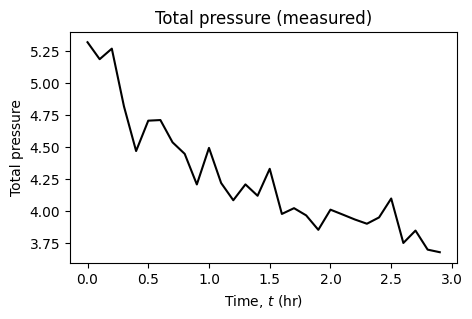

In [138]:
plt.figure(figsize=(5, 3))
plt.plot(dt*np.arange(T), y_cache, 'k')
plt.xlabel('Time, $t$ (hr)')
plt.ylabel('Total pressure')
plt.title('Total pressure (measured)')
plt.show()

### 3.2. Full Information Estimation of Pressures

Firstly, let us define the functions $\ell_{x_0}$, $\ell_w$, and $\ell_v$. Since $x_0$ is normally distributed, we have $\ell_{x_0}(x_0) = \|x_0-\tilde{x}_0\|_{P_0^{-1}}^2$. Likewise, $\ell_w(w) = \|w\|_{Q^{-1}}^2$ and $\ell_v(v) = \|v\|_{R^{-1}}^2$. Since $v$ is univariate, $\ell_v(v) = v^2/R$.

In [139]:
def ell_x0(x0):
    dx = x0 - x0_tilde
    return cs.dot(dx, cs.solve(P0, dx))

def ell_w(w):
    return cs.dot(w, cs.solve(Q, w))

def ell_v(v):
    return v*v / R


Let us define
- $\mathbf{x} = (x_0, \ldots, x_{T}) \in {\rm I\!R}^{n_x(T+1)}$,
- $\mathbf{w} = (w_0, \ldots, w_{T-1}) \in {\rm I\!R}^{n_x T}$
- $\mathbf{v} = (v_0, \ldots, v_{T-1}) \in {\rm I\!R}^{T}$

The decision variable is $z = (\mathbf{x}, \mathbf{w}, \mathbf{v})$.

The cost function is
$$L(z) =  \ell_{x_0}(x_0) + \sum_{t=0}^{T-1}\ell_{w_t}(w_t) + \ell_{v_t}(y_t - h(x_t)).$$
Let us define this function using CasADi.

In [140]:
# Cost function (using CasADi)
def cost(z):
    idx_w = nx*(T+1)
    xs = z[:idx_w]
    ws = z[idx_w:idx_w + nx*T]
    e = ell_x0(xs[:nx])
    for t in range(T):
        e  = e + ell_w(ws[t*nx:(t+1)*nx]) + ell_v(y_cache[t] - h(xs[t*nx:(t+1)*nx]))
    return e

# Decision variable
n = nx*(T+1) + nx*T
z_ = cs.SX.sym('z', n)

Next, we will define the equality constraints; let
$$c(z) = \begin{bmatrix}x_1 - f(x_0,w_0)\\x_2 - f(x_1,w_1)\\\vdots\\x_T - f(x_{T-1},w_{T-1})\end{bmatrix}$$
We have the (nonlinear) equality constraints $c(z) = 0$.

In [141]:
def dyn_constraint(z):
    c = []
    idx_w = nx*(T+1)
    ws = z[idx_w:idx_w + nx*T]
    for t in range(T):
        xt = z[t*nx:(t+1)*nx]
        xplus = z[(t+1)*nx:(t+2)*nx]
        wt = ws[t*nx:(t+1)*nx]
        c = cs.vertcat(c, xplus - f(xt, wt))
    return c

Lastly, we will impose the bound $x_t\geq 0$

In [142]:
lb = np.array([-np.inf]*n)
ub = np.array([np.inf]*n)
lb[:nx*T] = 0
bound = sopt.Bounds(lb, ub)

We have all the necessary ingredients to formulate and solve the optimisation problem. Firstly, to help the solver find an optimal solution, we will generate an initial guess of the system states by simulating the system while setting $w=0$ and starting from $x_0=\tilde{x}_0$.

In [143]:
x_guess = np.zeros((T+1, nx))
x = x0_tilde
x_guess[0, :] = x0_tilde.reshape((1, -1))
for t in range(T):
    x = f(x, [0, 0])
    x_guess[t + 1, :] = x.reshape((1, -1))

In [155]:
# Equality constraints
d_dyn_constraint = cs.jacobian(dyn_constraint(z_), z_)
d_dyn_constraint_fun = cs.Function('d_dyn_constraint', [z_], [d_dyn_constraint])
dyn_constraint_lam = lambda z: np.array(dyn_constraint(z)).flatten()
d_dyn_constraint_lam = lambda z: np.array(d_dyn_constraint_fun(z))
constr = sopt.NonlinearConstraint(dyn_constraint_lam, 0, 0, jac=d_dyn_constraint_lam, hess=sopt.BFGS())

# Jacobian of cost function
d_cost = cs.gradient(cost(z_), z_)
d_cost_fun = cs.Function('d_cost', [z_], [d_cost])
d_cost_lam = lambda x: np.array(d_cost_fun(x)).flatten()

# Solve the problem
guess= np.random.randn(n)
guess[:nx*(T+1)] = x_guess.flatten()
res = sopt.minimize(cost, guess,
                    method='SLSQP',
                    jac=d_cost_lam,
                    constraints=[constr],
                    bounds=bound,
                    options={'maxiter': 2000})

print(res.message)

Optimization terminated successfully


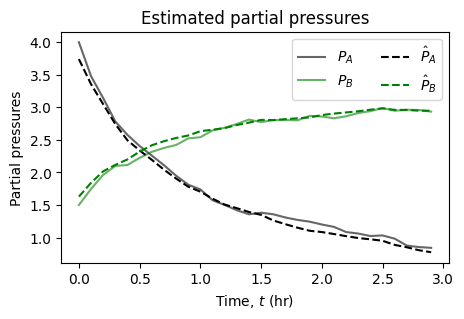

In [145]:
x_star = res.x[:nx*T].reshape((T, nx))

plt.figure(figsize=(5, 3))
plt.plot(dt*np.arange(T), x_cache[:T, 0], 'k', label='$P_A$', alpha=0.6)
plt.plot(dt*np.arange(T), x_cache[:T, 1], 'g', label='$P_B$', alpha=0.6)
plt.plot(dt*np.arange(T), x_star[:, 0], 'k--', label='$\\hat{P}_A$')
plt.plot(dt*np.arange(T), x_star[:, 1], 'g--', label='$\\hat{P}_B$')

plt.xlabel('Time, $t$ (hr)')
plt.ylabel('Partial pressures')
plt.title('Estimated partial pressures')
plt.legend(ncol=2)
plt.show()

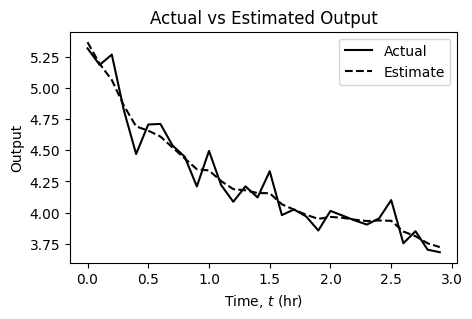

In [146]:
plt.figure(figsize=(5, 3))
plt.plot(dt*np.arange(T), y_cache, 'k', label='Actual')
plt.plot(dt*np.arange(T), np.sum(x_star, axis=1), 'k--', label='Estimate')
plt.legend()
plt.xlabel('Time, $t$ (hr)')
plt.ylabel('Output')
plt.title('Actual vs Estimated Output')
plt.show()